In [3]:
import pandas as pd
import lightgbm as lgb
import warnings
import gc
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
warnings.simplefilter('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")
submit_df = pd.read_csv("./submit_sample.csv", header=None)

In [5]:
train_df.shape, test_df.shape, submit_df.shape

((27100, 18), (18050, 17), (18050, 2))

In [6]:
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0


In [53]:
age_list = range(0, 120, 10)
age_ctgr = pd.cut(train_df['age'], bins=age_list)

target_data = pd.cut(train_df.loc[:, ['age', 'y']].groupby(['age', 'y']), bins=age_list)

plt.bar(range(0, 110, 10), target_data['y'])

ValueError: Input array must be 1 dimensional

<BarContainer object of 11 artists>

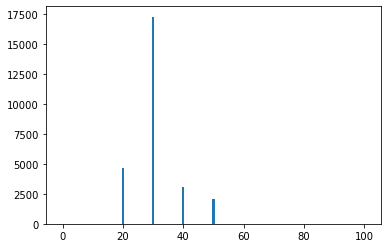

In [46]:
age_list = range(0, 120, 10)
age_ctgr = pd.cut(train_df['age'], bins=age_list)

plot_data = age_ctgr.value_counts().sort_index()
plt.bar(range(0, 110, 10), plot_data)

In [9]:
all_df = pd.concat([train_df, test_df])
del train_df, test_df
gc.collect()

81

In [11]:
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
for col in categorical_features:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(all_df[col])
    lbl.transform(all_df[col])
    all_df[col] = lbl.transform(all_df[col])

In [12]:
train_df = all_df[all_df['y']!=-999]
test_df = all_df[all_df['y']==-999]

In [14]:
y_train = train_df['y']
X_train = train_df.drop(['y', 'id'], axis=1)
X_test = test_df.drop(['y', 'id'], axis=1)

In [15]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.3, random_state=0, stratify=y_train)

In [17]:
lgb_train = lgb.Dataset(X_train, y_train, categorical_feature=categorical_features)
lgb_eval = lgb.Dataset(X_valid, y_valid, reference=lgb_train, categorical_feature=categorical_features)

params = {
    "objective":"binary"
}

model = lgb.train(
    params, lgb_train,
    valid_sets = [lgb_train, lgb_eval],
    verbose_eval = 10,
    num_boost_round = 1000,
    early_stopping_rounds=10
)

y_pred = model.predict(X_test, num_iteration=model.best_iteration)

Training until validation scores don't improve for 10 rounds
[10]	training's binary_logloss: 0.209427	valid_1's binary_logloss: 0.219289
[20]	training's binary_logloss: 0.191038	valid_1's binary_logloss: 0.209227
[30]	training's binary_logloss: 0.178925	valid_1's binary_logloss: 0.204428
[40]	training's binary_logloss: 0.169569	valid_1's binary_logloss: 0.203095
[50]	training's binary_logloss: 0.161995	valid_1's binary_logloss: 0.20335
Early stopping, best iteration is:
[48]	training's binary_logloss: 0.163581	valid_1's binary_logloss: 0.203038


In [18]:
y_pred

array([0.78074173, 0.07075874, 0.02624937, ..., 0.06533223, 0.0072316 ,
       0.13983576])

In [20]:
submit_df[1] = y_pred

In [21]:
submit_df.to_csv('./submit.csv', index=False, header=None)